╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 13. RNN-Basis**
# Section 4. RNN 모델 학습시키기



### _Objective_

1. Toy Dataset을 통해, 순환신경망(RNN)의 모델을 학습시켜 보도록 하겠습니다.<br>

╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

## Toy Dataset) 복잡한 주기함수 Dataset

Noise가 있는 복잡한 시계열 데이터셋에서 다음 값을 예측하는 RNN 모델을 구성해보도록 하겠습니다.

In [0]:
def generate_timeseries(n_steps=50):
    m_x = np.random.uniform(0,10)
    xs = np.linspace(0, 5, n_steps+1)
    ys = np.array([0.5*np.sin(2*np.pi*(x+m_x))+ np.cos(3*np.pi/2*(x+m_x/4))
                   + np.random.uniform(-0.1,0.1) for x in xs])
    return ys[:-1],ys[-1]

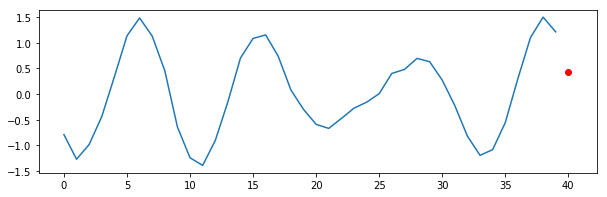

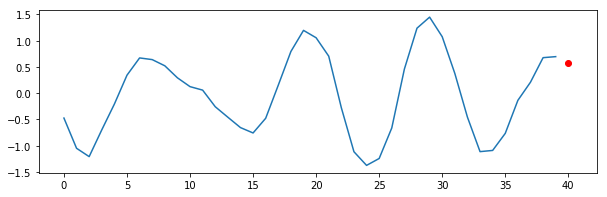

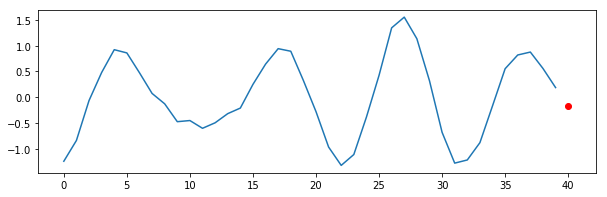

In [0]:
for _ in range(3):
    xs, ys = generate_timeseries(n_steps=40)
    timesteps = np.arange(len(xs)+1)
    plt.figure(figsize=(10,3))
    plt.plot(timesteps[:-1],xs)
    plt.scatter(timesteps[-1],ys,c='r')
    plt.show()

<br><br>

# \[ 1. RNN 모델에서의 역전파, BPTT(Back Propagation Through Time)  \]
---
---

> *기존의 역전파(Back Propagation)는 Feed-Forward의 연산 순서를 반대로 넘어가며 계산이 진행됩니다.* <br>
> *이와 다르게, RNN의 Feed Forward는 각 Time Step 별로 계산이 진행되며, Back Propagation도 이러한 Time Step에 따라 오차가 전파됩니다.*<br>
> *이러한 역전파의 과정을 배워보도록 하겠습니다.*<br>

<br>

## 1. BPTT 개념의 동기

---

* RNN 계층은 아래와 같이 가로로 펼친 신경망으로 볼 수 있습니다. 따라서 RNN의 학습도 보통의 신경망과 같이 Feed-Forward의 역순서로 진행되게 됩니다. 

### (1) Feed Forward 과정 펼치기

![Imgur](https://i.imgur.com/U0dIAe6.png)

우리는 왼쪽과 같이 Feed Forward 과정을 펼칠 수 있습니다.<br> 
이렇게 펼친 신경망의 순전파 과정은 Time-Step에 따라 진행되게 됩니다.<br>
각 Time Step에서 연산되는 식은 아래와 같습니다.

$
a^{(t)} = X^{(t)}\cdot W_{xh} + h^{(t-1)}\cdot W_{hh} + b_h \\
h^{(t)} = tanh(a^{(t)}) \\
O^{(t)} = h^{(t)}\cdot W_{hy} + b_{hy}
$

### (2) 각 Cell에서의 역전파

![Imgur](https://i.imgur.com/isk3bCo.png)

각 Cell에서의 역전파는 위의 수식에 따라 진행되게 됩니다. <br>
역전파를 통해, 각 가중치가 어떤식으로 바뀌는지는 아래의 수식을 살펴보면 됩니다. <br>


$\frac{\partial L}{\partial W_{xh}} = 
\frac{\partial L}{\partial h^{(t)}} \frac{\partial h^{(t)}}{\partial a^{(t)}} \frac{\partial a^{(t)}}{\partial W_{xh}} = \frac{L}{\partial h^{(t)}}tanh'(a^{(t)}) X^{(t)}
$

$\frac{\partial L}{\partial W_{hh}} = 
\frac{\partial L}{\partial h^{(t)}} \frac{\partial h^{(t)}}{\partial a^{(t)}} \frac{\partial a^{(t)}}{\partial W_{hh}} = \frac{L}{\partial h^{(t)}}tanh'(a^{(t)}) X^{(t)}
$

$
\frac{\partial L}{\partial h_{(t-1)}} = 
\frac{\partial L}{\partial h^{(t)}} \frac{\partial h^{(t)}}{\partial a^{(t)}} \frac{\partial a^{(t)}}{\partial h^{(t-1)}} = \frac{L}{\partial h^{(t)}}tanh'(a^{(t)}) W_{hh}
$

BPTT의 핵심은 제일 마지막 수식인 hidden state 간 오차가 어떤 식으로 전파되는지에 관한 수식입니다. <br> 가중치인 $W_{hh}$가 역전파가 진행됨에 따라 반복적으로 곱해지게 됨으로써, Gradient Exploding & Vanishing 문제가 쉽게 발생할 수 있습니다.
다음 섹션에서 이 내용을 중심으로 구체적으로 파악해 볼 예정입니다.

<br><br>

# \[ 2. Keras에서 RNN 모델 학습시키기  \]
---
---

> *Keras에서의 RNN은 BPTT(Back propagation Through Time)을 지원합니다.*<br>
> *Keras로 모델을 학습시켜 보도록 하겠습니다.*<br>

<br>

## 1. 모델 구성하기

---

* 우리는 50번의 TimeStep을 받은 후 그 다음 Timestep으로 어떤 값이 올지 예측하는 모델을 구성하도록 하겠습니다.<br>

### (1) RNN 모델 구성하기

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
K.clear_session()

n_inputs = 1
n_steps = 50
n_neurons = 200
n_outputs = n_inputs

inputs = Input(shape=(n_steps,n_inputs))
hidden = SimpleRNN(n_neurons, return_state=False)(inputs)
output = Dense(1)(hidden)

model = Model(inputs,output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


### (2) Optimizer와 Loss 구성하기

In [0]:
model.compile(loss='mse',
              optimizer=Adam(lr=1e-4))

### (3) Dataset Generator 구성하기

Keras를 학습시키기 위해서는 학습할 데이터를 계속 공급해주는 Generator 함수를 구현해주어야 합니다.<br>

In [0]:
def timeseries_generator(n_steps=50, batch_size=32):
    while True:
        batch_xs, batch_ys = [], []
        for _ in range(batch_size):
            x, y = generate_timeseries(n_steps)
            batch_xs.append(x[:,np.newaxis])
            batch_ys.append(y[np.newaxis])
        yield np.stack(batch_xs), np.stack(batch_ys)

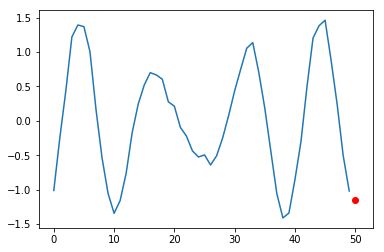

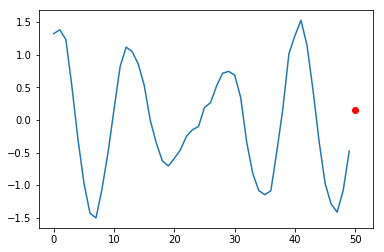

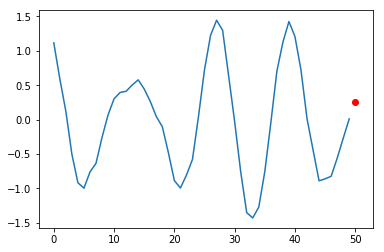

In [0]:
train_gen = timeseries_generator(batch_size=3)

batch_x, batch_y = next(train_gen)

for xs, y in zip(batch_x, batch_y):
    plt.plot(xs)
    plt.scatter(len(xs), y, c='r')
    plt.show()

### (3 ) Keras Model 학습시키기

위에서 구현한 Generator을 통해, fit_generator로 모델을 학습시킬 수 있습니다. 이렇게 구현할 경우,  Keras에서는 비동기적으로 동작하기 때문에 보다 빠르게 학습시킬 수 있습니다. 

In [0]:
batch_size = 16
train_gen = timeseries_generator(n_steps, batch_size)

hist = model.fit_generator(train_gen,
                           steps_per_epoch=20,
                           epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20/20 [==============================] - 1s 36ms/step - loss: 0.0469
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0077
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0051
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0045
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 8/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 9/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0039
Epoch 10/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0043


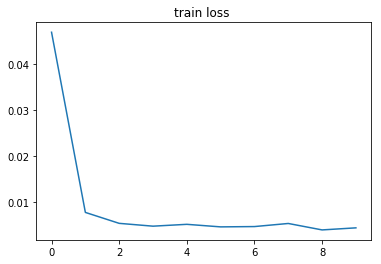

In [0]:
plt.title("train loss ")
plt.plot(hist.history['loss'])
plt.show()

### (4) 결과 확인하기

초록 색이 실제 정답이고, 붉은 색이 예측한 값입니다.<br> 그 둘의 값이 거의 비슷한 것으로 보아 잘 학습되었다고 볼 수 있습니다.

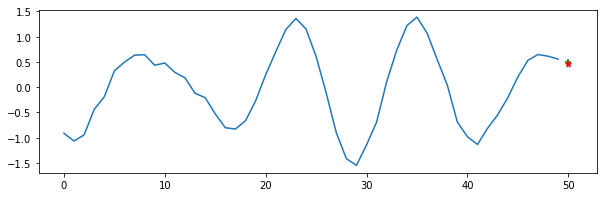

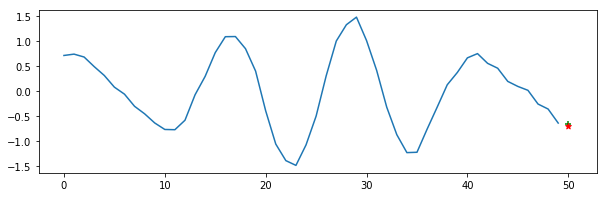

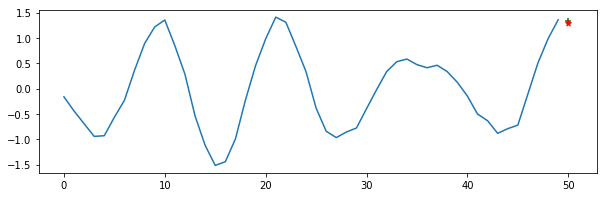

In [0]:
# 생성된 RNN
for _ in range(3):
    xs, y_true = generate_timeseries(n_steps)
    timesteps = np.arange(len(xs)+1)
    
    xs = xs[np.newaxis,:,np.newaxis]
    y_pred = model.predict(xs).squeeze()
    
    
    plt.figure(figsize=(10,3))
    plt.plot(timesteps[:-1],xs.squeeze())
    plt.scatter(timesteps[-1],y_true,c='g',marker='+')
    plt.scatter(timesteps[-1],y_pred,c='r',marker='*')    
    plt.show()

우리는 재귀적으로 예측한 값을 다시 입력값으로 넣는 방식을 통해, 아래와 같이 무한히 파동을 생성할 수 있습니다.

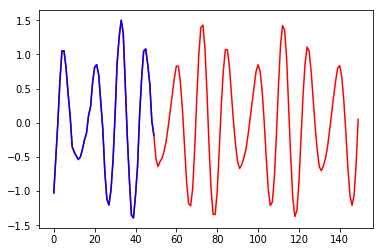

In [0]:
# 생성된 RNN
xs, ys = next(train_gen)
sequence = xs[:1]
start_seq = sequence.squeeze().copy()

for iteration in range(100):
    output = model.predict(sequence[:,-50:])
    sequence = np.concatenate([sequence,output[np.newaxis]],axis=1)

plt.plot(sequence.squeeze(),'r')
plt.plot(start_seq,'b')
plt.show()